# Import and process brain data from BOLD5000

In [8]:
import numpy as np
import pandas as pd
import os
import glob
import pingouin as pg
import seaborn as sns

In [3]:
# 3 complete subjects in the BOLD5000 dataset, downloaded from here: https://bold5000-dataset.github.io/website/
subjects = ['CSI1','CSI2','CSI3']
regions = ['LHEarlyVis','LHPPA','LHRSC','RHPPA','RHEarlyVis','RHOPA','RHRSC','LHOPA','LHLOC','RHLOC'] 

# NOTE: There are typos in the BOLD5000 dataset for the ROI names. 
# We have edited those names directly on our copy of the BOLD5000 data; 
# https://figshare.com/articles/dataset/BOLD5000_Release_2_0/14456124?file=28404132


# Data folder for .npy files relative to code location on SCANN Lab dropbox
brain_related_data_folder = os.path.join('..','..','..','data','brain_related_v.2.0','BOLD5000_GLMsingle_ROI_betas','py')
#brain_related_data_folder = 'BOLD5000_GLMsingle_ROI_betas/py'

# Get all .npy files from that folder
roi_file_list = glob.glob(os.path.join(brain_related_data_folder,'*.npy'))

# Looking for 40 files (10 ROIs per 4 subj)
assert(len(roi_file_list) == 40)


def convert_behavioral_matrices(df):
    
    # Do some processing of the data frame to make it amenable to correlations later.
    imgnames = df['presentedImage'].to_list()
    df = df.iloc[:,1:]
    df = df.transpose()
    df = df.to_numpy()
    
    out_df = pd.DataFrame(df, columns = imgnames)
    
    return out_df, imgnames


# Catscenes data, taken from the linguistic task data:
catscenes_ling = pd.read_csv(os.path.join('..','..','data','lingDirectionsAverage.csv'))
#catscenes_ling = pd.read_csv('lingDirectionsAverage.csv')
catscenes_ling, catscenes_imgnames = convert_behavioral_matrices(catscenes_ling)

catscenes_analog = pd.read_csv(os.path.join('..','..','data','analogData_37_bins_Average.csv'))
#catscenes_analog = pd.read_csv('analogData_37_bins_Average.csv')
catscenes_analog, analog_imgnames = convert_behavioral_matrices(catscenes_analog)

display(catscenes_analog.head())

,ATM1.jpg,ATM4.jpg,HorseRaceTrack.jpg,RVinside2.jpg,ShowJumping7.jpg,airplanecabin1.jpg,airplanecabin3.jpg,airplanecabin5.jpg,airportTerminal2.jpg,airportTerminal3.jpg,...,windmill2.jpg,wineVineyard2.jpg,wineVineyard8.jpg,wineVineyard9.jpg,winebarrel2.jpg,winebarrel3.jpg,winebarrel4.jpg,wrestlingring7.jpg,yogastudio1.jpg,yogastudio4.jpg
0,-0.459077,-0.79347,-0.594217,-0.275748,-0.678053,-0.217193,-0.505958,-0.483363,-0.582676,-0.713513,...,-0.875465,-0.377609,-0.193481,-0.231386,-0.483767,-0.247637,-0.694133,-0.713275,-0.558093,-0.531031
1,-0.459077,-0.79347,-0.594217,-0.275748,-0.678053,-0.217193,-0.505958,-0.483363,-0.582676,-0.713513,...,-0.875465,-0.377609,-0.193481,-0.231386,-0.483767,-0.247637,-0.694133,-0.713275,-0.558093,-0.531031
2,-0.459077,-0.79347,-0.594217,-0.275748,-0.678053,-0.217193,-0.505958,-0.483363,-0.582676,-0.713513,...,-0.875465,-0.377609,-0.193481,-0.231386,-0.483767,-0.247637,-0.694133,-0.713275,-0.558093,-0.531031
3,-0.459077,-0.79347,-0.594217,-0.275748,-0.678053,-0.217193,-0.505958,-0.483363,-0.582676,-0.713513,...,-0.875465,-0.377609,-0.193481,-0.231386,-0.483767,-0.247637,-0.694133,-0.713275,-0.558093,-0.531031
4,-0.459077,-0.79347,-0.594217,-0.275748,-0.678053,-0.217193,-0.499793,-0.483363,-0.582676,-0.683056,...,-0.767540,-0.377609,-0.193481,-0.231386,-0.483767,-0.247637,-0.694133,-0.690168,-0.558093,-0.527943


C:\Users\stevenweisberg\AppData\Local\Continuum\anaconda3\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
C:\Users\stevenweisberg\AppData\Local\Continuum\anaconda3\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


# Analog Correlations File

Load in the Analog Correlations file, and verify what the top third, top half, and top two thirds correlation values are. 

Then select all images that are in the top third (or top half or top two thirds) and return the list of images. 

# Handle the image names

In [4]:
def process_img_list(bold5000_imgname_file,catscenes_imgnames=catscenes_imgnames,verbose=False):
    """
    A function that will remove duplicates. Previously, BOLD5000 stimlists had "rep"
       appended to each subsequent presentation of an image. Those "rep" prefixes 
       have been removed, so we need to remove duplicates ourselves. 
       We then also need to remove all images that we never presented."""
    
    with open(bold5000_imgname_file,'r') as f:
        img_list = pd.read_csv(f,header=None,names=['imgnames'])
        
        if verbose:
            print(img_list.head())
            print(f'Before dropping duplicates, length = {len(img_list)}')
        
        # Remove all duplicates besides the first image
        img_list.drop_duplicates(keep='first',inplace=True)
        
        if verbose:
            print(f'After dropping duplicates, length = {len(img_list)}')
        
        # Only keep images on the list IF they appeared in the Catscenes study.
        img_list = img_list[img_list['imgnames'].isin(catscenes_imgnames)]
        
        if verbose:
            print(f'After dropping non-catscenes images, length = {len(img_list)}')
        
    return img_list

# List of image names as presented per subject.
bold5000_imgname_folder = os.path.join('..','..','..','data','brain_related_v.2.0','BOLD5000_imgnames')
#bold5000_imgname_folder = 'BOLD5000_GLMsingle_ROI_betas/BOLD5000_imgnames'
bold5000_imgname_file_list = glob.glob(os.path.join(bold5000_imgname_folder,'*'))
#bold5000_imgname_file_list = glob.glob(os.path.join(bold5000_imgname_folder,'*'))

# Loop through every subjects list of images presented from BOLD5000
img_list_indices = {}
img_list_names = {}
for bold5000_imgname_file in bold5000_imgname_file_list:
    # Initialize a dataframe
    img_list = pd.DataFrame()
    
    # Grab the subject ID from the file name
    subj = bold5000_imgname_file.split(os.sep)[-1].split('_')[0]

    # Turn the raw list from BOLD5000 into the list (in order) of only stimuli we presented in 
    # catscenes, the first time they were presented. 
    img_list = process_img_list(bold5000_imgname_file)
    
    # We save out the indices and the names of the images in separate dictionaries. 
    img_list_names[subj] = img_list['imgnames'].to_list()
    img_list_indices[subj] = img_list.index.to_list()


In [5]:
# Initialize this with a multiindex - https://pandas.pydata.org/docs/user_guide/advanced.html
#brain_corr = pd.DataFrame(index=[subjects,regions,['partial','ling','analog']])

def create_correlation_vector(df, imgnames=catscenes_imgnames):
    
    """
    From the dataframe that is 500 image columns by N rows,
    create a 500x500 correlation matrix. 
    
    From the correlation matrix, return just the lower triangle
    (below the diagonal) as a vector.
    """
    
    # Calculate correlation matrix columns by columns.
    corr_matrix = df.corr()

    # Sort both axes. 
    corr_matrix.sort_index(inplace=True,axis=0)
    corr_matrix.sort_index(inplace=True,axis=1)
    corr_np = corr_matrix.to_numpy()
    
    #https://numpy.org/doc/stable/reference/generated/numpy.tril_indices.html
    # Select just the lower triangle of the matrix, excluding diagonal:    
    lower_triangle_indices = np.tril_indices(corr_matrix.shape[0],-1)
    
    # Convert the lower triangle of the correlation matrix into a 1d vector.
    corr_1d = np.empty(len(lower_triangle_indices))
    corr_1d = np.reshape(corr_np[lower_triangle_indices],corr_np[lower_triangle_indices].size)
    
    return corr_1d, corr_matrix.columns.to_list()

def calculate_brain_behavior_correlation(corr_1d_1,corr_1d_2,order_1,order_2):
    
    assert(order_1==order_2)
    
    return np.corrcoef(corr_1d_1,corr_1d_2)[0,1]

#df = pd.DataFrame()
corr_list = [] 

analog_1d, analog_order = create_correlation_vector(catscenes_analog)
ling_1d, ling_order = create_correlation_vector(catscenes_ling)

for file in roi_file_list:
    
    # Get the subj id and the region name from the roi file we loaded in.
    subj = file.split(os.sep)[-1].split('_')[0]
    if subj in subjects:
        region = file.split(os.sep)[-1].split('_')[-1].split('.')[0]

        # Load in the roi file and trim the unused columns. 
        beta = np.load(file)
        beta = beta[img_list_indices[subj],:]
        beta = np.transpose(beta)
        df = pd.DataFrame(beta,columns=img_list_names[subj])

        # Create correlation vector.
        region_1d,region_order = create_correlation_vector(df)

        # Calculate correlation between analog + ROI
        corr_analog = [calculate_brain_behavior_correlation(region_1d,analog_1d,analog_order,region_order).round(4),region,'analog',subj]
        print(corr_analog)        
        corr_list.append(corr_analog)
        
        # Calculate correlation between analog + ROI
        corr_ling = [calculate_brain_behavior_correlation(region_1d,ling_1d,ling_order,region_order).round(4),region,'ling',subj]
        print(corr_ling)
        corr_list.append(corr_ling)
        
        df_brain= pd.DataFrame({'region_1d': region_1d,'analog_1d': analog_1d, 'ling_1d': ling_1d})
        # Calculate partial correlation between analog and ROI with ling as covariate
        corr_an_ling_partial = [pg.partial_corr(data=df_brain,x='region_1d', y='analog_1d', covar='ling_1d').round(4).r.pearson,region,'partial_analog',subj]
        print(corr_an_ling_partial)
        corr_list.append(corr_an_ling_partial)
        
        # Calculate partial correlation between ling and ROI with analog as covariate
        corr_ling_an_partial = [pg.partial_corr(data=df_brain,x='region_1d', y='ling_1d', covar='analog_1d').round(4).r.pearson,region,'partial_ling',subj]
        print(corr_ling_an_partial)
        corr_list.append(corr_ling_an_partial)
        
        

[0.0025, 'LHEarlyVis', 'analog', 'CSI1']
[-0.0112, 'LHEarlyVis', 'ling', 'CSI1']
[0.0069, 'LHEarlyVis', 'partial_analog', 'CSI1']
[-0.0129, 'LHEarlyVis', 'partial_ling', 'CSI1']
[0.0065, 'LHLOC', 'analog', 'CSI1']
[0.004, 'LHLOC', 'ling', 'CSI1']
[0.0055, 'LHLOC', 'partial_analog', 'CSI1']
[0.0018, 'LHLOC', 'partial_ling', 'CSI1']
[-0.0009, 'LHOPA', 'analog', 'CSI1']
[0.0031, 'LHOPA', 'ling', 'CSI1']
[-0.0022, 'LHOPA', 'partial_analog', 'CSI1']
[0.0037, 'LHOPA', 'partial_ling', 'CSI1']
[-0.011, 'LHPPA', 'analog', 'CSI1']
[-0.0026, 'LHPPA', 'ling', 'CSI1']
[-0.0108, 'LHPPA', 'partial_analog', 'CSI1']
[0.0014, 'LHPPA', 'partial_ling', 'CSI1']
[-0.0047, 'LHRSC', 'analog', 'CSI1']
[0.0042, 'LHRSC', 'ling', 'CSI1']
[-0.0066, 'LHRSC', 'partial_analog', 'CSI1']
[0.0063, 'LHRSC', 'partial_ling', 'CSI1']
[0.0096, 'RHEarlyVis', 'analog', 'CSI1']
[-0.0184, 'RHEarlyVis', 'ling', 'CSI1']
[0.0173, 'RHEarlyVis', 'partial_analog', 'CSI1']
[-0.0233, 'RHEarlyVis', 'partial_ling', 'CSI1']
[0.0049, 'RHLOC

In [6]:
df_corr_list= pd.DataFrame (corr_list, columns = ['corr_value','region','behavior','subject'])

print(np.corrcoef(analog_1d,ling_1d)[0,1])
print(np.corrcoef(analog_1d,region_1d)[0,1])
print(np.corrcoef(ling_1d,region_1d)[0,1])
print(pg.partial_corr(data=df_brain,x='region_1d', y='analog_1d', covar='ling_1d').round(4).r.pearson)
print(pg.partial_corr(data=df_brain,x='region_1d', y='ling_1d', covar='analog_1d').round(4).r.pearson)

df_corr_list.head()

0.3542101502654456
0.0016276378770576241
0.012663466204742365
-0.0031
0.0129


,corr_value,region,behavior,subject
0,0.0025,LHEarlyVis,analog,CSI1
1,-0.0112,LHEarlyVis,ling,CSI1
2,0.0069,LHEarlyVis,partial_analog,CSI1
3,-0.0129,LHEarlyVis,partial_ling,CSI1
4,0.0065,LHLOC,analog,CSI1


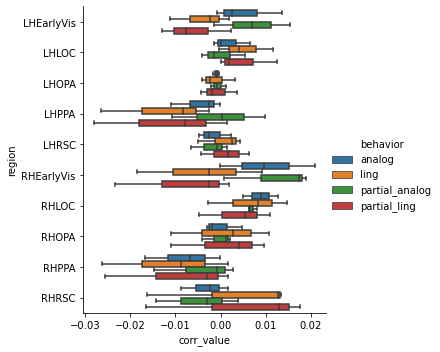

In [26]:


#df_corr_list.boxplot(column='corr_value',by=['behavior'])
sns.catplot(x="corr_value", hue="behavior", y="region", data=df_corr_list, kind="box")

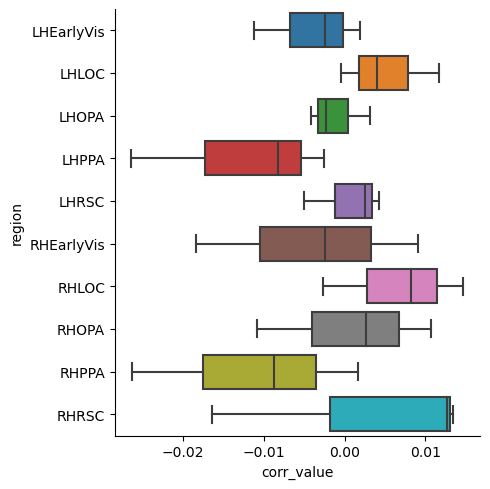

In [18]:
sns.catplot(x="corr_value", y="region", data=df_corr_list[df_corr_list['behavior'] == 'ling'],kind="box")

In [8]:
row = df_corr_list.loc[(df_corr_list['region']=='RHRSC') & (df_corr_list['behavior']=='ling') & (df_corr_list['subject']=='CSI3')]

In [15]:
df_corr_list[df_corr_list['region']=='RHLOC']

,corr_value,region,behavior,subject
24,0.0049,RHLOC,analog,CSI1
25,-0.0027,RHLOC,ling,CSI1
26,0.0063,RHLOC,partial_analog,CSI1
27,-0.0048,RHLOC,partial_ling,CSI1
64,0.0127,RHLOC,analog,CSI2
65,0.0147,RHLOC,ling,CSI2
66,0.0080,RHLOC,partial_analog,CSI2
67,0.0109,RHLOC,partial_ling,CSI2
104,0.0089,RHLOC,analog,CSI3
105,0.0082,RHLOC,ling,CSI3
